In [123]:
import librosa
import pyworld
from scipy.io import wavfile

import IPython
from IPython.display import Audio

import matplotlib.pyplot as plt
import numpy as np
import pysptk

import os

import tqdm

from nnmnkwii.preprocessing.alignment import DTWAligner
from nnmnkwii.metrics import melcd

import math
import cmath

In [124]:
DATASET_PATH = "../../../datasets/cmu_artic"
EXAMPLE_EXT = "/cmu_us_clb_arctic/wav/arctic_a0001.wav"

Sampling frequency:  16000
58960


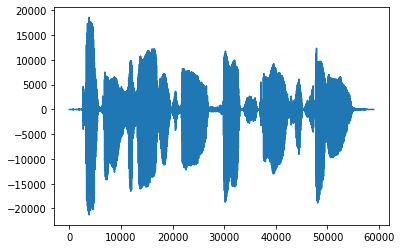

In [125]:
sampling_frequency, data = wavfile.read(DATASET_PATH + EXAMPLE_EXT)
IPython.display.display(Audio(data, rate = sampling_frequency))
plt.plot(data)
print("Sampling frequency: ", sampling_frequency)
print(data.size)

In [126]:
# split data
sample = []
for i in range(0, data.size, 160):
#     if (i + 400 > )
    s = data[i:i+400]
    
    sample.append(s)
    
sample = sample[: len(sample) - 3]
sample = np.array(sample, dtype=np.csingle)

print(sample.size)
print(sample[0].size)
print(sample)

146400
400
[[  0.+0.j   0.+0.j  -2.+0.j ...  -3.+0.j   2.+0.j   2.+0.j]
 [  4.+0.j   0.+0.j   1.+0.j ...   2.+0.j  -2.+0.j   1.+0.j]
 [ -2.+0.j  -2.+0.j   0.+0.j ...  19.+0.j -34.+0.j  23.+0.j]
 ...
 [  4.+0.j   5.+0.j   4.+0.j ...   1.+0.j   0.+0.j   1.+0.j]
 [ -2.+0.j  -2.+0.j  -2.+0.j ...  -2.+0.j  -3.+0.j  -1.+0.j]
 [ -1.+0.j  -1.+0.j  -1.+0.j ...   2.+0.j  -3.+0.j   2.+0.j]]


/home/genustori07/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/genustori07/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


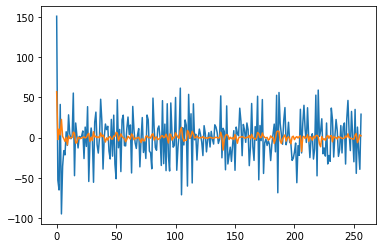

In [127]:
# discrete fourier transform
sample_S = []
sample_P = []

sample_size = 366

for i in range(0, sample_size):
    # each 400 points
    S_i = []
    P_i = []
#     for k in range(0, 257):
#         curr_S_i = 0
        
#         for n in range(0, 400):
#             curr_S_i += sample[i][n] * cmath.exp(-1j * 2 * math.pi * k * n / 400)
            
#         curr_P_i = 0

        
#         S_i.append(curr_S_i)
    
#         P_i.append(curr_P_i)
    S_i = np.fft.fft(sample[i], n=512)
    S_i = S_i[:257]
    
    P_i = S_i * S_i / 400
    
        
    sample_S.append(S_i)
    sample_P.append(P_i)
        
plt.plot(S_i)
plt.plot(P_i)

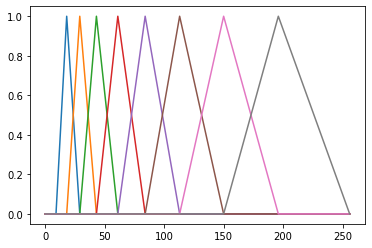

In [128]:
def mel(f):
    return 1125 * np.log(1 + f / 700)

# convert back into freq
def mel_to_freq(m):
    return 700 * (np.exp(m / 1125) - 1)

num_filter = 10

lower_bound = 300
upper_bound = 8000

lower_mel = mel(lower_bound)
upper_mel = mel(upper_bound)


MEL = np.linspace(lower_mel, upper_mel, num=num_filter)
HERTZ = mel_to_freq(MEL)
fft_bins = np.floor(513 * HERTZ / sampling_frequency)

power_bank = []

for m in range(1, num_filter-1):
    H_m = []
    h_m = 0
    
    for k in range(0, 257):
        if (k >= fft_bins[m - 1] and k <= fft_bins[m]):
            h_m = (k - fft_bins[m - 1]) / (fft_bins[m] - fft_bins[m - 1])
        elif (k >= fft_bins[m] and k <= fft_bins[m + 1]):
            h_m = (-k + fft_bins[m + 1]) / (fft_bins[m+1] - fft_bins[m])
        else:
            h_m = 0
        H_m.append(h_m)
    power_bank.append(H_m)
    
            
for p in power_bank:
    plt.plot(p)

/home/genustori07/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/genustori07/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/genustori07/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/genustori07/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/genustori07/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, 

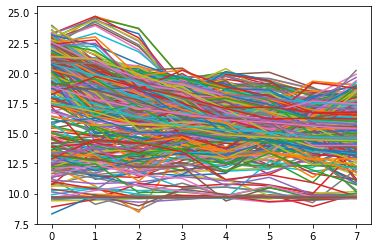

In [129]:
# calculate and take log of powerbank energies
filterbank_energies = []

for i in range(len(sample_P)):
    sample_P_i_arr = [] 
    for j in range(len(power_bank)):
        sample_P_i = np.matmul(sample_P[i], np.array(power_bank[j]).T) + MEL
        sample_P_i = np.sum(sample_P_i)
        sample_P_i = np.log(sample_P_i)
        sample_P_i_arr.append(sample_P_i)

        
    
    filterbank_energies.append(sample_P_i_arr)

# print(np.array(sample_P).shape)
# print(np.array(power_bank).shape)
# print(np.array(filterbank_energies).shape)
# print(np.array(filterbank_energies))
for p in np.array(filterbank_energies):
    plt.plot(p)
    
    



/home/genustori07/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/genustori07/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/genustori07/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/genustori07/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/genustori07/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, 

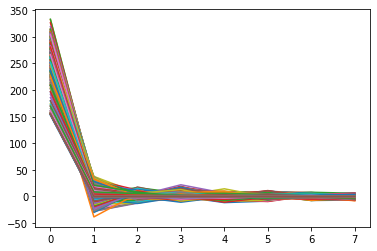

In [130]:
# Discrete cosine transform(DCT)
DCT = []
# N = len(sample_P)

# for i in range(N):
#     dct_i = 1/N * sample_P[]

import scipy.fftpack

# DCT = scipy.fftpack.dct(filterbank_energies[0])

for i in range(sample_size):
    DCT.append(scipy.fftpack.dct(filterbank_energies[i]))

for i in DCT:
    plt.plot(i)
    
DCT = np.array(DCT)

# print(np.array(filterbank_energies).shape)


In [144]:
mfcc = librosa.feature.mfcc(np.array(data, dtype=np.float), sampling_frequency, n_mfcc=40, win_length=400, hop_length=160)
inverted_audio = librosa.feature.inverse.mfcc_to_audio(mfcc, sr=sampling_frequency, win_length=400, hop_length=160)
IPython.display.display(Audio(inverted_audio, rate = sampling_frequency))

In [122]:
DCT_transpose = DCT.T
inverted_audio_poopoo = librosa.feature.inverse.mfcc_to_audio(DCT_tranpose.real)
IPython.display.display(Audio(inverted_audio_poopoo, rate = sampling_frequency))

ValueError: failed to initialize intent(inout) array -- expected elsize=8 but got 16 -- input 'D' not compatible to 'd'